In [1]:
import torch
import sklearn

from dataset import NiiFolder
from transforms import RandomHorizontalFlip2D, RandomHorizontalFlip3D

import torch 
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, datasets

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import copy
import random

from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
num_classes = 2
batch_size = 10

ngpu = 2

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [3]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=num_classes):
        
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(60, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x
class LeNet3D(nn.Module):
    def __init__(self):
        super(LeNet3D, self).__init__()
        
        self.pool = nn.AvgPool3d(kernel_size=(1, 3, 3))

        self.conv1 = nn.Conv3d(3, 6, kernel_size=(2,32,32))
        self.conv2 = nn.Conv3d(6, 16, kernel_size=(2,16,16))
        self.conv3 = nn.Conv3d(16, 32, kernel_size=(2,8,8))
        self.conv4 = nn.Conv3d(32, 64, kernel_size=(2,4,4))
        
        self.fc1 = nn.Linear(9216, 16 * 5 * 5 * 5)
        self.fc2 = nn.Linear(16 * 5 * 5 * 5, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 9216)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.shape).numpy() * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
nii_transforms = transforms.Compose([
    RandomHorizontalFlip2D(),
    AddGaussianNoise()
])

dataroot = "/data/metastasises-ws/data/metastasises_dataset/train2D/"

full_dataset =  NiiFolder(dataroot, transform = nii_transforms)


dataloader =  DataLoader(full_dataset, batch_size=batch_size, shuffle=True )

In [5]:
model2D = nn.DataParallel(AlexNet().to(device))

model2D.load_state_dict(torch.load("./models/AlexNet2D_30eph.pth"))

<All keys matched successfully>

In [6]:
import math

y_true = []
y_pred = []

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

for i, data in enumerate(dataloader, 0):
    inputs, labels = data[0].float().to(device), data[1].to(device)

    outputs = model2D(inputs)
    _, predicted = torch.max(outputs.data, 1)
    print(labels)
    
    tmp = outputs.data.cpu().numpy().tolist()
    for label in labels:
        if label == 0:
            y_true.append([1,0])
        else:
            y_true.append([0,1])
    for i in range(len(tmp)):
        y_pred.append([sigmoid(tmp[i][0]),sigmoid(tmp[i][1])])

tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
tensor([1, 1, 0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 1, 1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
tensor([1, 0, 1, 1, 1], device='cuda:0')


In [7]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

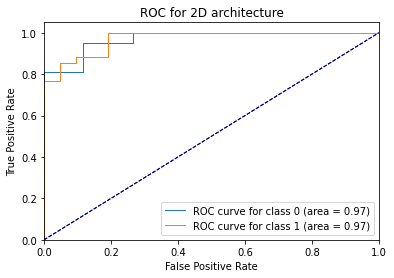

In [8]:
plt.figure()
lw = 1
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve for class %d (area = %0.2f)' % (i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for 2D architecture')
    plt.legend(loc="lower right")
plt.show()

In [9]:
nii_transforms = transforms.Compose([
    RandomHorizontalFlip2D(),
    AddGaussianNoise()
])

dataroot = "/data/metastasises-ws/data/metastasises_dataset/train3D/"

full_dataset =  NiiFolder(dataroot, transform = nii_transforms)


dataloader =  DataLoader(full_dataset, batch_size=batch_size, shuffle=True )

model3D = nn.DataParallel(LeNet3D().to(device))

model3D.load_state_dict(torch.load("./models/LeNet3D_20eph.pth"))

<All keys matched successfully>

In [10]:
y_true = []
y_pred = []


for i, data in enumerate(dataloader, 0):
    inputs, labels = data[0].float().to(device), data[1].to(device)

    outputs = model3D(inputs)
    _, predicted = torch.max(outputs.data, 1)
    print(labels)
    
    tmp = outputs.data.cpu().numpy().tolist()
    for label in labels:
        if label == 0:
            y_true.append([1,0])
        else:
            y_true.append([0,1])
    for i in range(len(tmp)):
        y_pred.append([sigmoid(tmp[i][0]),sigmoid(tmp[i][1])])

tensor([1, 0, 0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 0, 0, 1], device='cuda:0')


In [11]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

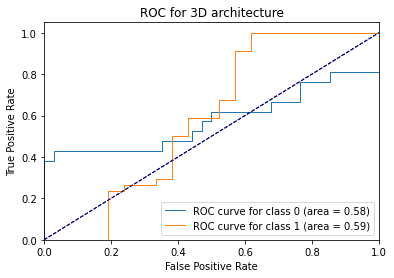

In [12]:
plt.figure()
lw = 1
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve for class %d (area = %0.2f)' % (i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for 3D architecture')
    plt.legend(loc="lower right")
plt.show()